In [84]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import traceback
import matplotlib.lines as mlines

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib

import os
import pickle
import traceback
from PIL import Image

#feedbacks = ['MerianSIDM', 'MerianCDM']
feedbacks = ['BWMDC', 'MerianCDM']
#feedbacks = ['MerianSIDM']
classifications = ['d', 'e', 'i']
output_folder = '../../Figures/Images/Classified'

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as path_effects

def projected_axis_ratio(phi, theta, B, C):
    """
    Calculate the projected axis ratio q for a triaxial ellipsoid with axis ratios B/A and C/A
    viewed from angles (phi, theta).

    Based on Simonneau et al. (1998) as used in Kado-Fong et al. (2020).

    Parameters:
        phi (float or array): Azimuthal viewing angle in radians
        theta (float or array): Polar viewing angle in radians
        B (float or array): B/A axis ratio (intermediate/major)
        C (float or array): C/A axis ratio (minor/major)

    Returns:
        float or array: Projected axis ratio q = b/a
    """
    # Calculate f and g as per equations in Simonneau et al. (1998)
    f = np.sqrt(
        (C * np.sin(theta) * np.cos(phi)) ** 2 +
        (B * C * np.sin(theta) * np.sin(phi)) ** 2 +
        (B * np.cos(theta)) ** 2
    )

    g = (
            np.cos(phi) ** 2 + np.cos(theta) ** 2 * np.sin(phi) ** 2 +
            B ** 2 * (np.sin(phi) ** 2 + np.cos(theta) ** 2 * np.cos(phi) ** 2) +
            (C * np.sin(theta)) ** 2
    )

    # Calculate h
    h = np.sqrt((g - 2 * f) / (g + 2 * f))

    # Calculate q
    q = (1 - h) / (1 + h)

    return q


def project_to_image_plane(vector, phi, theta):
    """
    Project a 3D vector onto the image plane defined by viewing angles phi and theta.
    
    Parameters:
        vector (numpy.array): 3D vector to project
        phi (float): Azimuthal viewing angle in radians
        theta (float): Polar viewing angle in radians
        
    Returns:
        tuple: (u, v) coordinates on the image plane
    """
    # Define camera direction vector (normal to the image plane)
    camera_dir = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    # Define u-axis (first basis vector for the image plane)
    # Use cross product with up vector to get first basis vector
    up_vector = np.array([0, 0, 1])
    u_basis = np.cross(up_vector, camera_dir)
    
    # If camera direction is aligned with up vector, use a different reference
    if np.allclose(u_basis, 0):
        u_basis = np.array([1, 0, 0])
    
    # Normalize u basis
    u_basis = u_basis / np.linalg.norm(u_basis)
    
    # Define v-axis (second basis vector, orthogonal to both camera_dir and u_basis)
    v_basis = np.cross(camera_dir, u_basis)
    v_basis = v_basis / np.linalg.norm(v_basis)
    
    # Project vector onto the u-v plane
    u_coord = np.dot(vector, u_basis)
    v_coord = np.dot(vector, v_basis)
    
    return u_coord, v_coord


def create_galaxy_grid(sim, hid, Images, Profiles, StShapes, Masses, output_folder, feedback="feedback"):
    # Create figure with higher DPI for better resolution
    dpi = 80


    rotations = ['x000y000', 'x090y000']#, 'x090y120', 'x090y240']
    angles = [[0,0], [90,0]]#, [90,120], [90,240]]
    fig = plt.figure(figsize=(50, 25), dpi=dpi)

    # Use GridSpec for more control over subplot spacing
    # Small positive spacing to prevent subplots from touching
    gs = GridSpec(1, 2, figure=fig)
    #plt.box(on= None)
    #plt.axis('off')
    try:
        # Add galaxy properties as a title
        Reff = Profiles[str(hid)]['x000y000']['Reff']
        Rhalf = Profiles[str(hid)]['x000y000']['Rhalf']
        ba = StShapes[(hid)]["ba_smooth"](2*Reff)
        ca = StShapes[(hid)]["ca_smooth"](2*Reff)
        rbins = StShapes[(hid)]["rbins"]
        shape_rotations = StShapes[(hid)]["rotations"] #       rotation_matrices : np.ndarray The rotation matrices for each shell
        #get rotation index closest to 2*Reff
        rot_index = np.argmin(np.abs(rbins - 2*Reff))
        #get rotation matrix for that index
        rotation_matrix = shape_rotations[rot_index]
        print(rotation_matrix)
        
        
        #plot projected axis ratio on face-on image

        fig.text(0.5, 0.9605, rf'Shape at 2$R_{{\text{{eff}}}}$: $Q$ = {ba:.2f}, $S$ = {ca:.2f}',
                color='white', fontsize=70, ha='center',
                 backgroundcolor='black',
                #path_effects=[path_effects.Stroke(linewidth=20, foreground='black'),
                              #path_effects.Normal()]
                 )

        #print(f'Stellar b/a: {ba:.2f}, c/a: {ca:.2f}')
    except Exception as e:
        print(f"Error getting b/a, c/a for halo {hid}: {e}")

    try:

        #width of the image is 6*Rhalf but measurement is taken at 2*Reff from face-on image

        for i, rot in enumerate(rotations):
            # Create subplot with GridSpec
            #ax = fig.add_subplot(gs[i // 2, i % 2])
            ax = fig.add_subplot(gs[i])
            #ax.set_frame_on(False)
            #ax.set_axis_off()
            print(rot)

            # Get image data
            img = Images[str(hid)][rot]
            vmin = np.max([np.min(img), 1000])

            # Display the image
            im = ax.imshow(np.log10(img), cmap='magma', vmin=np.log10(vmin))
            # Add text labels
            if i == 0:
                label_text = 'Face-on'
            else:
                label_text = f'Side-on'

            ax.text(0.5, 0.95, label_text,
                   transform=ax.transAxes,
                   fontsize=50,
                   color='white',
                   ha='center',
                   va='top',
                   fontweight='bold')

            # Remove all axes elements
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            #add projected ellipse to each image

            #parse angles from rot string
            theta,phi = angles[i]
            #convert to degrees
            phi = np.radians(phi)
            theta = np.radians(theta)

            #convert ba and ca into pixels
            kpc_per_pixel = 6*Rhalf/img.shape[0]
            a = 2*Reff
            b = a*ba
            c = a*ca
            #convert a,b,c to pixels
            a_pix = a/kpc_per_pixel
            b_pix = b/kpc_per_pixel
            c_pix = c/kpc_per_pixel


            #print(f'in kpc: a: {a}, b: {b}, c: {c}, in pixels a: {a_pix}, b: {b_pix}, c: {c_pix}')
            #get projected axis ratio
            q = projected_axis_ratio(phi, theta, ba, ca)
            #print(f'Orientations: {theta}, {phi}')
            print(f'Projected axis ratio: {q:.2f}, Q: {ba:.2f}, S: {ca:.2f}')
            
            #find where the prinicpal axis of the ellipssoids are in 3d: 
            #rotate the principal axis of the ellipsoid by the rotation matrix
            #a in x direction, b in y direction, c in z direction in the new coordinate system 
            #get the rotated vector
            #test rotation matrix as identity matrix
            if i == 1:
                rotation_matrix = np.eye(3)
            #check if rotation matrix contains nans
            if rotation_matrix[0,0] == np.nan:
                rotation_matrix = np.eye(3)

            a_rot = np.dot(rotation_matrix, np.array([1, 0, 0]))
            b_rot = np.dot(rotation_matrix, np.array([0, ba, 0]))
            c_rot = np.dot(rotation_matrix, np.array([0, 0, ca]))
            # Project the rotated vectors onto the plane of the image
            a_u, a_v = project_to_image_plane(a_rot, phi, theta)
            b_u, b_v = project_to_image_plane(b_rot, phi, theta)
            c_u, c_v = project_to_image_plane(c_rot, phi, theta)
            
            a_mag = np.sqrt(a_u**2 + a_v**2)
            b_mag = np.sqrt(b_u**2 + b_v**2)
            c_mag = np.sqrt(c_u**2 + c_v**2)
            
            # print(f'Projected a: {a_u:.2f}, {a_v:.2f}, magnitude: {a_mag:.2f}')
            # print(f'Projected b: {b_u:.2f}, {b_v:.2f}, magnitude: {b_mag:.2f}')
            # print(f'Projected c: {c_u:.2f}, {c_v:.2f}, magnitude: {c_mag:.2f}')
            
            # Find direction each axis is pointing
            a_dir = np.arctan2(a_v, a_u)
            b_dir = np.arctan2(b_v, b_u)
            c_dir = np.arctan2(c_v, c_u)
            
            #print(f'Direction a: {np.degrees(a_dir):.2f}°, b: {np.degrees(b_dir):.2f}°, c: {np.degrees(c_dir):.2f}°')
            
            # Set projected ellipse angle to direction of largest magnitude
            if a_mag > b_mag and a_mag > c_mag:
                angle = a_dir
                #print('a is largest')
            elif b_mag > a_mag and b_mag > c_mag:
                #print('b is largest')
                angle = b_dir
            else:
                #print('c is largest')
                angle = c_dir
            
            # Convert angle to degrees for Matplotlib
            angle_deg = np.degrees(angle)
            print(f'Projected ellipse angle: {angle_deg:.2f}°')
            
            # Get projected ellipse - note that angle needs to be in degrees
            ellipse = matplotlib.patches.Ellipse((img.shape[1]//2, img.shape[0]//2),
                                                 a_pix, a_pix*q, angle=angle_deg,
                                                 fill=False, edgecolor='cyan', linewidth=8)
            ax.add_patch(ellipse)







    except Exception as e:
        print(f"Error loading image for halo {hid}: {e}")
        traceback.print_exc()
        return None


    # Save with maximum quality and custom adjusted bounds
    output_file = f'{output_folder}/{sim}.{feedback}.{hid}.png'
    plt.tight_layout()
    # Adjust bottom margin - make it tighter
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.close(fig)  # Important to free memory

    return output_file





In [85]:




for feedback in feedbacks:
    pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
    classified_galaxies = {}

    print(os.path.exists(pickle_path))
    print(pickle_path)
    if os.path.exists(pickle_path):
        sims = pickle.load(open(pickle_path, 'rb'))
        #print(sims)
        for sim in sims:

            classified_galaxies[sim] = {}
            try:
                DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.DMShapes.pickle', 'rb'))
                StShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.3DShapes.pickle', 'rb'))
                Profiles = pickle.load(open(f'../../Data/{sim}.{feedback}.Profiles.pickle', 'rb'))
                Masses = pickle.load(open(f'../../Data/BasicData/{feedback}.Masses.pickle', 'rb'))
                Images = pickle.load(open(f'../../Data/{sim}.{feedback}.Images.pickle', 'rb'))
            except:
                print(f"Error loading shapes for simulation {sim}")
                continue
            #print(f"Processing simulation: {sim}")
            for hid in sims[sim]['goodhalos']:
                #output_folder = '/home/bk639/OverLeaf/ShapePaper'
                output_folder = '../../Figures/Images/Classified'


                #for the moment only process halos Storm 1, r468 1, h229 2
                # sims_use = ['r431', 'r468', 'h229']
                # hids = [1, 1, 2]
                # if sim not in sims_use or hid not in hids:
                #     output_folder = '../../Figures/Images/Classified'
                #     continue
                print(f"Processing halo {hid} in simulation {sim}")




                # Create figure with higher DPI for better resolution

                rotations = ['x000y000', 'x090y000', 'x090y120', 'x090y240']
                classified_galaxies[sim][hid] = {}
                create_galaxy_grid(sim, hid, Images, Profiles, StShapes, Masses, output_folder, feedback)

                Reff = Profiles[str(hid)]['x000y000']['Reff']
                Rhalf = Profiles[str(hid)]['x000y000']['Rhalf']
                ba = StShapes[(hid)]["ba_smooth"](2*Reff)
                ca = StShapes[(hid)]["ca_smooth"](2*Reff)

                try:
                    jz_jcirc_avg = Masses[sim][str(hid)]['jz_jcirc_avg']
                    j_crit = Masses[sim][str(hid)]['j_crit']
                    dt_star = Masses[sim][str(hid)]['dt_star']
                    dt_gas = Masses[sim][str(hid)]['dt_gas']
                    dt_total = Masses[sim][str(hid)]['dt_total']
                    print(f'jz/jcirc: {jz_jcirc_avg:.2f}, jcrit: {j_crit}, dt_star: {dt_star:.2f}, dt_gas: {dt_gas:.2f}, dt_total: {dt_total:.2f}')
                    print(f'{np.log10(Masses[sim][str(hid)]['Mstar']):.2f}')
                except:
                    print(f"Error getting jz/jcirc for halo {hid}")
                    print(traceback.format_exc())

                # #automatic class
                user_input = None
                if ba > 0.65 and ca < 0.4:
                    user_input = 'd'
                else:
                    user_input = 'e'



                # plt.show()
                # plt.pause(0.2)
                # #automatic class
                # user_input = None
                # if -1 < jz_jcirc_avg < 1e-2:
                #     user_input = 'e'
                # elif .2 < jz_jcirc_avg < 1:
                #     user_input = 'd'
                # if np.log10(Masses[sim][str(hid)]['Mstar']) < 7.5:
                #     user_input = 'e'
                #     classified_galaxies[sim][hid] = user_input
                #
                # #manual class
                # if user_input is None:
                #
                #     while True:
                #         user_input = input(f"Classify this galaxy disk,irrgular,ellipcital d/i/e or quit").lower()
                #         if user_input in classifications or user_input == 'quit':
                #             break
                #         print(f"Invalid input. Please enter one of {', '.join(classifications)}, or 'quit'.")
                #
                #     if user_input == 'quit':
                #         print("Exiting early.")
                #         break
                #
                classified_galaxies[sim][hid] = user_input
                # fig.suptitle(f'Halo {hid} in simulation {sim} is {user_input}')
                #
                # # Create the output folder if it doesn't exist
                # os.makedirs(output_folder, exist_ok=True)
                #tight layout:
               # plt.tight_layout()
                # Save the image in the classified folder
                #output_file = f'{output_folder}/{sim}.{feedback}.{hid}.png'
                #fig.savefig(output_file)


                #plt.close(fig)
    #             break
    #         break
    #     break
    # break





            #
            # if user_input == 'quit':
            #     break

    # Save the classification results
    with open(f'galaxy_classifications_{feedback}-v2.pickle', 'wb') as f:
        pickle.dump(classified_galaxies, f)

print("Classification complete. Results saved.")

True
../PickleFiles/SimulationInfo.BWMDC.pickle
Processing halo 1 in simulation cptmarvel
[[-0.32412901 -0.70142373 -0.63477959]
 [ 0.35212821  0.5333338  -0.76912989]
 [ 0.87803537 -0.47282111  0.07412213]]
x000y000
Projected axis ratio: 0.89, Q: 0.89, S: 0.35
Projected ellipse angle: 142.75°
x090y000
Projected axis ratio: 0.35, Q: 0.89, S: 0.35
Projected ellipse angle: 0.00°
jz/jcirc: 0.07, jcrit: 0.07755711674690247, dt_star: 0.00, dt_gas: 0.24, dt_total: 0.26
7.74
Processing halo 2 in simulation cptmarvel
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
x000y000
Projected axis ratio: 0.96, Q: 0.96, S: 0.24
Projected ellipse angle: nan°
x090y000
Projected axis ratio: 0.24, Q: 0.96, S: 0.24
Projected ellipse angle: 0.00°
jz/jcirc: 0.08, jcrit: 0.035987645387649536, dt_star: 0.00, dt_gas: 0.57, dt_total: 0.57
7.17
Processing halo 3 in simulation cptmarvel
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
x000y000
Projected axis ratio: 0.63, Q: 0.63, S: 0.39
Projected ellipse angle: nan°
x090

In [ ]:

print("Final results:")
print(disk_sims)
results_file = f'disk_sims_results.pickle'
# Save the final results to a pickle file
with open(results_file, 'wb') as f:
    pickle.dump(disk_sims, f)

print(f"Results saved to {results_file}")

In [ ]:
#load ../

In [ ]:
pip install getkey

In [ ]:
file = '/home/bk639/MorphologyMeasurements/Figures/Images/r431.MerianCDM/1/1.x000y000.png'
file = '/home/bk639/MorphologyMeasurements/Figures/Images/r431.MerianCDM/1/1.x000.y000.png'
#see if file exists
print(os.path.exists(file))


In [ ]:
#display results of pickle file 
import re
disks = {}
results_file = 'disk_sims_results.pickle'
with open(results_file, 'rb') as f:
    disk_sims = pickle.load(f)
    #append sim halo to list of sims, only for sims of the form rXXX or rXXXX using match string for numbers only
    for sim in disk_sims:
        if re.match(r'r\d{3,4}', sim):
            if sim not in disks:
                disks[sim] = []
            for hid in disk_sims[sim]:
                if disk_sims[sim][hid]:
                    disks[sim].append(hid)
print(disks)

Processing BWMDC...
Data summary for BWMDC:
             hid   jz_jcirc     j_crit
count  51.000000  39.000000  51.000000
mean    9.725490   0.122379   0.376930
std    11.301466   0.550518   0.302280
min     1.000000  -0.034667   0.010837
25%     3.000000   0.000086   0.088332
50%     7.000000   0.006375   0.230535
75%    10.500000   0.042518   0.700000
max    65.000000   3.445466   0.700000
Processing MerianCDM...
Data summary for MerianCDM:
             hid   jz_jcirc     j_crit
count  38.000000  35.000000  38.000000
mean    1.105263   0.163284   0.288476
std     0.388307   0.150624   0.172497
min     1.000000  -0.003651   0.060109
25%     1.000000   0.016402   0.169169
50%     1.000000   0.121176   0.242099
75%     1.000000   0.289335   0.378116
max     3.000000   0.515400   0.700000
Number of data points with jz_jcirc < 10^-2.5
22


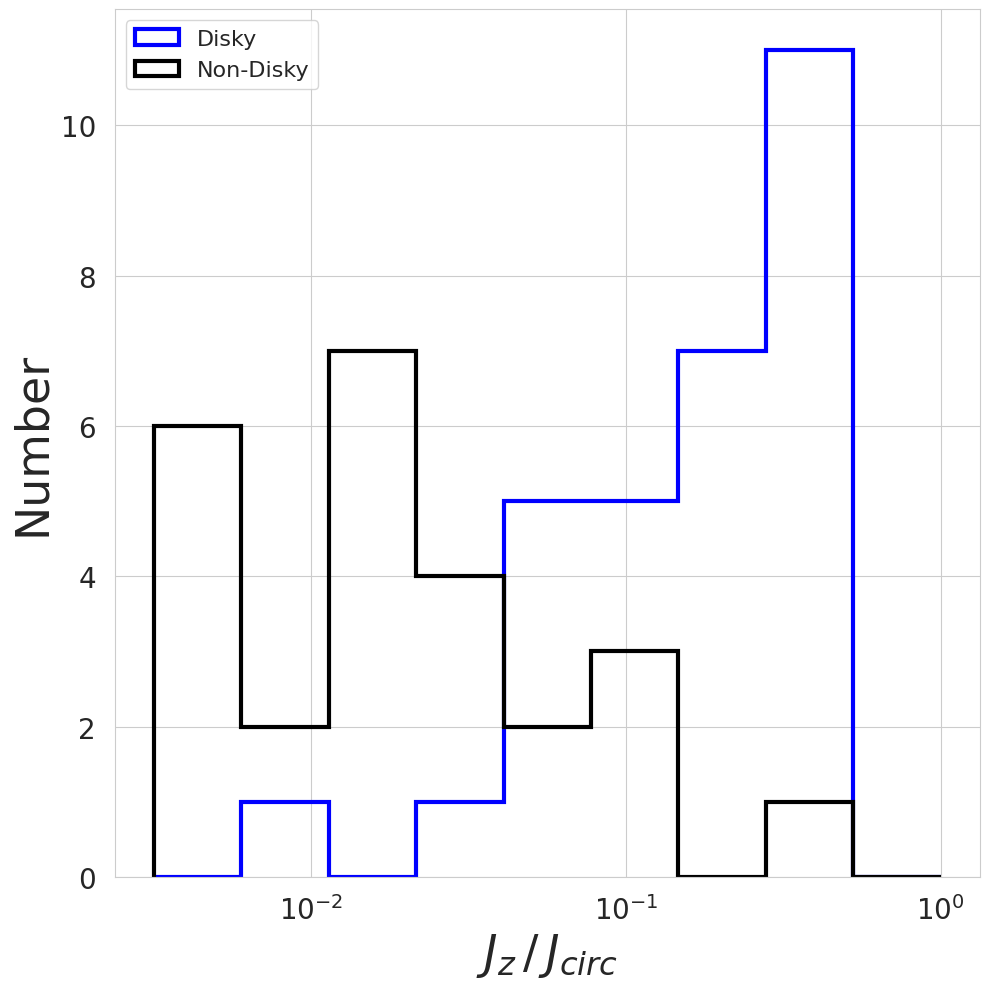

Combined plot saved.

Outliers:
Feedback: BWMDC, Simulation: storm, Halo ID: 31, Reason: jz_jcirc out of range: 1603.3889815340751, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 2, Reason: jz_jcirc out of range: 11293.603801718218, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 3, Reason: jz_jcirc out of range: 600718.6679464484, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 4, Reason: jz_jcirc out of range: 258.64951587130605, classification: Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 23, Reason: jz_jcirc out of range: 1079.8149239426032, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 27, Reason: jz_jcirc out of range: -423.8648342047455, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 38, Reason: jz_jcirc out of range: 5796.555742842233, classification: Non-Disky
Feedback: BWMDC, Simulation: h148, Halo ID: 65, Reason: jz_jcirc out of range: 509.1509724191755, classificat

In [86]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import traceback

# Function to load data
def load_data(feedback):
    with open(f'galaxy_classifications_{feedback}-v2.pickle', 'rb') as f:
        classifications = pickle.load(f)

    with open(f'../../Data/BasicData/{feedback}.Masses.pickle', 'rb') as f:
        masses = pickle.load(f)

    return classifications, masses

# Function to handle outliers
def handle_outliers(df, jz_jcirc_min=-10, jz_jcirc_max=10):
    outliers = []

    for index, row in df.iterrows():
        if not (jz_jcirc_min <= row['jz_jcirc'] <= jz_jcirc_max):
            outliers.append({
                'feedback': row['feedback'],
                'sim': row['sim'],
                'hid': row['hid'],
                'reason': f"jz_jcirc out of range: {row['jz_jcirc']}",
                'classification': row['classification']
            })
            df.at[index, 'jz_jcirc'] = np.nan

    return df, outliers

# Function to process data
def process_data(classifications, masses, feedback, jz_jcirc_min=-10, jz_jcirc_max=10):
    data = []
    for sim in classifications:
        for hid, class_ in classifications[sim].items():
            if str(hid) in masses[sim]:
                halo_data = masses[sim][str(hid)]
                jz_jcirc = float(halo_data['jz_jcirc_avg'])

                # Combine 'e' and 'i' into 'Non-Disky'
                classification = 'Disky' if class_ == 'd' else 'Non-Disky'

                data.append({
                    'feedback': feedback,
                    'sim': sim,
                    'hid': hid,
                    'classification': classification,
                    'jz_jcirc': jz_jcirc,
                    'j_crit': halo_data['j_crit'],
                    'dt_star': halo_data['dt_star'],
                    'dt_gas': halo_data['dt_gas'],
                    'dt_total': halo_data['dt_total'],
                    #'stellar_mass': halo_data['stellar_mass'],
                    
                })

    df = pd.DataFrame(data)
    df, outliers = handle_outliers(df, jz_jcirc_min, jz_jcirc_max)
    return df, outliers

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

def create_plot(df, y_column, output_filename):
    #clear previous plot
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    #matplotlib defualts


    labels = ['Disky', 'Non-Disky']
    colors = ['blue', 'black']

    bin_edges = np.logspace(-2.5, 0, 10)
    #print(bin_edges)
    
    #count any data points with jz_jcirc < 10^-3 to 10^-3
    print('Number of data points with jz_jcirc < 10^-2.5')
    print(df[df['jz_jcirc'] < 10**-2.5][y_column].count())
    

    # Get absolute value of jz_jcirc
    df['jz_jcirc'] = df['jz_jcirc'].abs()

    for label, color in zip(labels, colors):
        #print(color, label)
        #print(df[df['classification'] == label][y_column])

        ax.hist(df[df['classification'] == label][y_column],
                bins=bin_edges,
                color=color,
                edgecolor=color,
                linewidth=3,
                label=label,
                density=False,
                histtype='step')

    ax.set_xlabel(r'$J_z \,/\, J_{circ}$', fontsize=33)
    ax.set_ylabel('Number', fontsize=33) 
    ax.set_xscale('log')

    #increase size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)
    #increase size of subticks
    ax.tick_params(axis='both', which='minor', labelsize=5, width=1.5, length=6)
    ax.legend(fontsize=16)

    plt.tight_layout()
    plt.savefig(output_filename, bbox_inches='tight')
    plt.show()


# Main execution
feedbacks = ['BWMDC', 'MerianCDM']

# Adjustable parameters for outlier removal
JZ_JCIRC_MIN = -10
JZ_JCIRC_MAX = 10

# Adjustable y-axis limit
y_limit = (-0.1, 0.5)

all_data = []
all_outliers = []

for feedback in feedbacks:
    print(f"Processing {feedback}...")
    classifications, masses = load_data(feedback)
    df, outliers = process_data(classifications, masses, feedback, JZ_JCIRC_MIN, JZ_JCIRC_MAX)

    all_data.append(df)
    all_outliers.extend(outliers)

    print(f"Data summary for {feedback}:")
    print(df.describe())

df = pd.concat(all_data, ignore_index=True)

df['jz_jcirc/j_crit'] = (df['jz_jcirc'] / df['j_crit'])

create_plot(df, 'jz_jcirc', f'/home/bk639/OverLeaf/ShapePaper/jz_jcirc.png')
print("Combined plot saved.")

print("\nOutliers:")
for outlier in all_outliers:
    print(f"Feedback: {outlier['feedback']}, Simulation: {outlier['sim']}, Halo ID: {outlier['hid']}, Reason: {outlier['reason']}, classification: {outlier['classification']}")

print("Plot created successfully.")

In [ ]:
import re
from tangos.input_handlers import finding


# examples strs 1023.romulus25.3072g1HsbBH.000076  r1023.romulus25.3072g1HsbBH.001056
test_str = 'r1023.romulus25.3072g1HsbBH.000096/ahf_200/r1023.romulus25.3072g1HsbBH.000096'

snapshot_pattern = ['/*.00[0-9][0-9][0-9][0-9]']
#snapshot_pattern = ['*']
exclude_pattern = ['*.startrun', 'tipsy.info', '*.AHF*','*.parameter','*ahf_200*']
#exclude_pattern = []
base = '/data/REPOSITORY/romulus_zooms/r1023.romulus25.3072g1HsbBH'
results = sorted(finding.find(basename=base + "/", patterns=snapshot_pattern, ignore=exclude_pattern))

print(results)
print(len(results))

#if snapshot_pattern.match(test_str) and not exclude_pattern.match(test_str):
    #print('Matched')


r634
Processing simulation: r634.romulus25si2s50v35
SIDM Stellar b/a: 0.83, c/a: 0.41
CDM Stellar b/a: 0.96, c/a: 0.25
Difference b/a: -0.13, c/a: 0.16
SIDM jz/jcirc: 0.13, jcrit: 0.38, dt_star: 0.04, dt_gas: 0.48, dt_total: 0.46
CDM jz/jcirc: 0.21, jcrit: 0.39, dt_star: 0.09, dt_gas: 0.58, dt_total: 0.56
Difference jz/jcirc: -0.08, jcrit: -0.01, dt_star: -0.05, dt_gas: -0.10, dt_total: -0.10


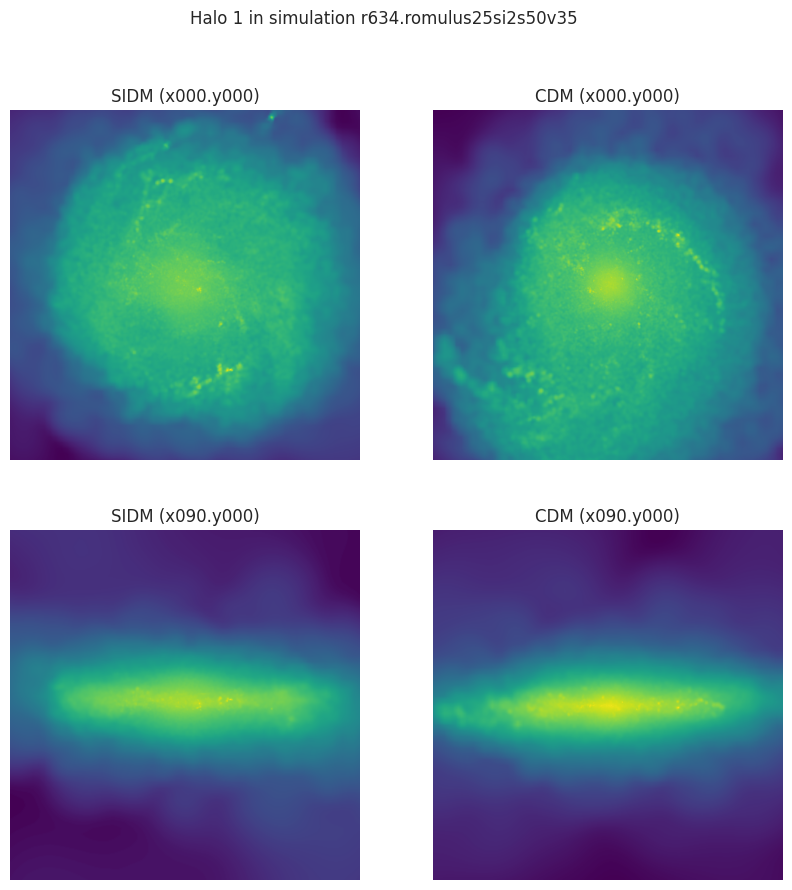

r492
Processing simulation: r492.romulus25si2s50v35
SIDM Stellar b/a: 0.92, c/a: 0.23
CDM Stellar b/a: 0.70, c/a: 0.21
Difference b/a: 0.22, c/a: 0.02
SIDM jz/jcirc: 0.24, jcrit: 0.14, dt_star: 0.00, dt_gas: 0.63, dt_total: 0.62
CDM jz/jcirc: 0.30, jcrit: 0.21, dt_star: 0.06, dt_gas: 0.62, dt_total: 0.61
Difference jz/jcirc: -0.06, jcrit: -0.07, dt_star: -0.06, dt_gas: 0.01, dt_total: 0.01


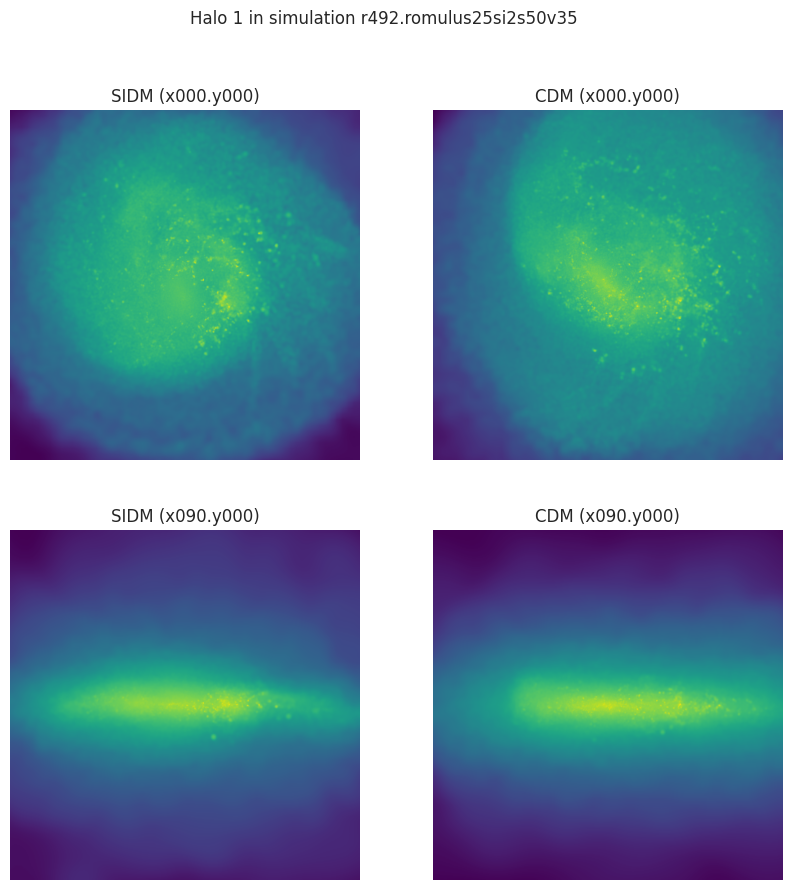

r468
Processing simulation: r468.romulus25si2s50v35
SIDM Stellar b/a: 0.85, c/a: 0.46
CDM Stellar b/a: 0.73, c/a: 0.43
Difference b/a: 0.12, c/a: 0.03
SIDM jz/jcirc: 0.12, jcrit: 0.36, dt_star: 0.01, dt_gas: 0.08, dt_total: 0.10
CDM jz/jcirc: 0.08, jcrit: 0.36, dt_star: 0.01, dt_gas: 0.13, dt_total: 0.12
Difference jz/jcirc: 0.04, jcrit: 0.00, dt_star: -0.00, dt_gas: -0.06, dt_total: -0.02


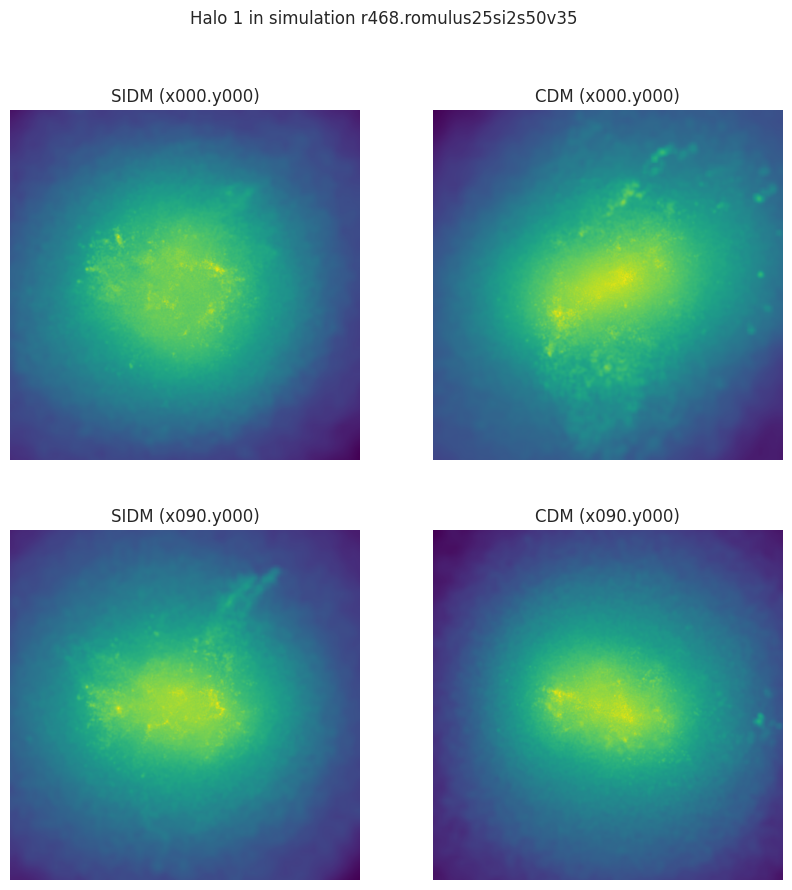

r488
Processing simulation: r488.romulus25si2s50v35
SIDM Stellar b/a: 0.74, c/a: 0.41
CDM Stellar b/a: 0.61, c/a: 0.52
Difference b/a: 0.14, c/a: -0.11
SIDM jz/jcirc: 0.25, jcrit: 0.26, dt_star: 0.03, dt_gas: 0.44, dt_total: 0.44
CDM jz/jcirc: -0.00, jcrit: 0.70, dt_star: 0.00, dt_gas: 0.00, dt_total: 0.00
Difference jz/jcirc: 0.25, jcrit: -0.44, dt_star: 0.03, dt_gas: 0.44, dt_total: 0.44


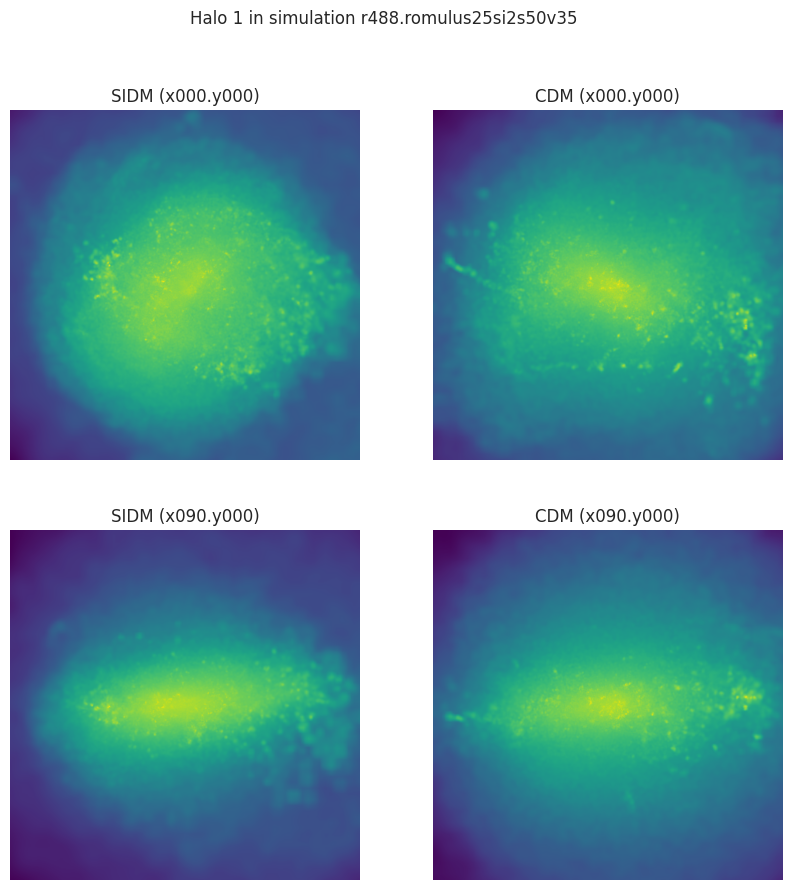

r544
Processing simulation: r544.romulus25si2s50v35
SIDM Stellar b/a: 0.65, c/a: 0.20
CDM Stellar b/a: 0.89, c/a: 0.22
Difference b/a: -0.24, c/a: -0.02
SIDM jz/jcirc: 0.34, jcrit: 0.20, dt_star: 0.09, dt_gas: 0.51, dt_total: 0.53
CDM jz/jcirc: 0.33, jcrit: 0.15, dt_star: 0.00, dt_gas: 0.55, dt_total: 0.58
Difference jz/jcirc: 0.01, jcrit: 0.05, dt_star: 0.08, dt_gas: -0.04, dt_total: -0.05


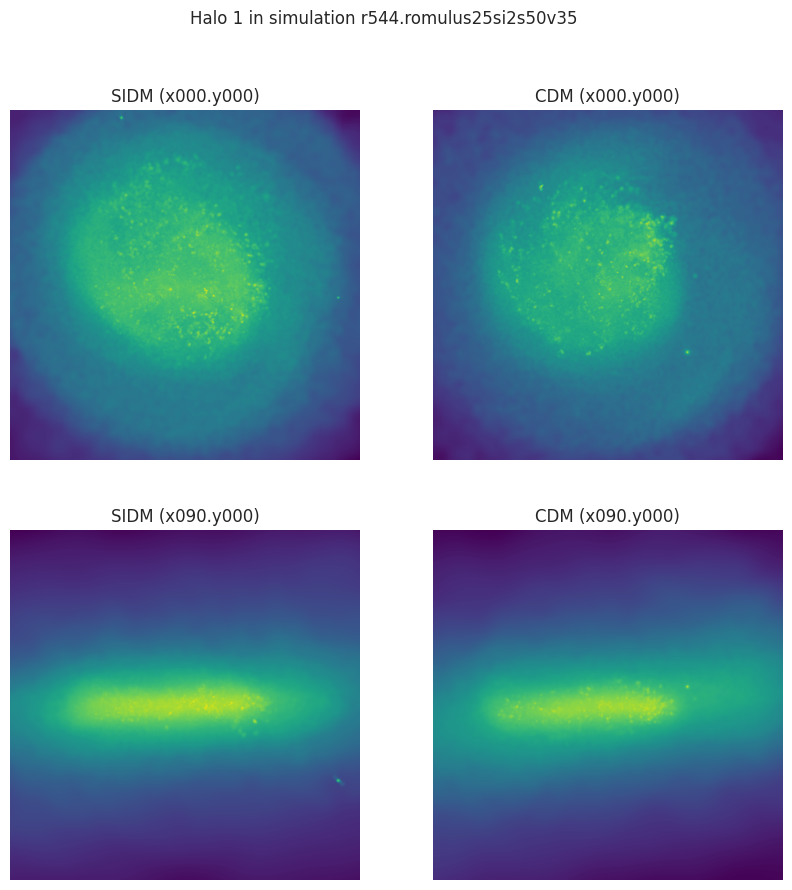

r597
Processing simulation: r597.romulus25si2s50v35
SIDM Stellar b/a: 0.73, c/a: 0.29
CDM Stellar b/a: 0.85, c/a: 0.25
Difference b/a: -0.12, c/a: 0.04
SIDM jz/jcirc: 0.19, jcrit: 0.41, dt_star: 0.11, dt_gas: 0.43, dt_total: 0.41
CDM jz/jcirc: 0.32, jcrit: 0.26, dt_star: 0.08, dt_gas: 0.50, dt_total: 0.51
Difference jz/jcirc: -0.13, jcrit: 0.14, dt_star: 0.02, dt_gas: -0.07, dt_total: -0.10


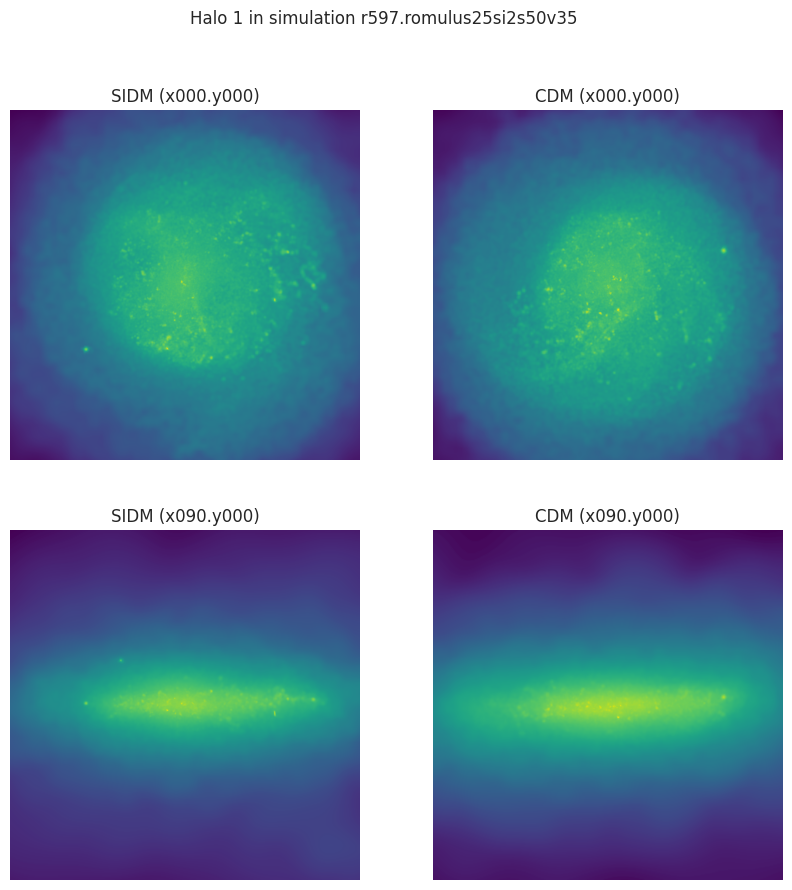

r523
Processing simulation: r523.romulus25si2s50v35
SIDM Stellar b/a: 0.96, c/a: 0.27
CDM Stellar b/a: 0.85, c/a: 0.29
Difference b/a: 0.11, c/a: -0.02
SIDM jz/jcirc: 0.27, jcrit: 0.15, dt_star: 0.00, dt_gas: 0.44, dt_total: 0.47
CDM jz/jcirc: 0.34, jcrit: 0.16, dt_star: 0.13, dt_gas: 0.42, dt_total: 0.45
Difference jz/jcirc: -0.07, jcrit: -0.01, dt_star: -0.13, dt_gas: 0.02, dt_total: 0.02


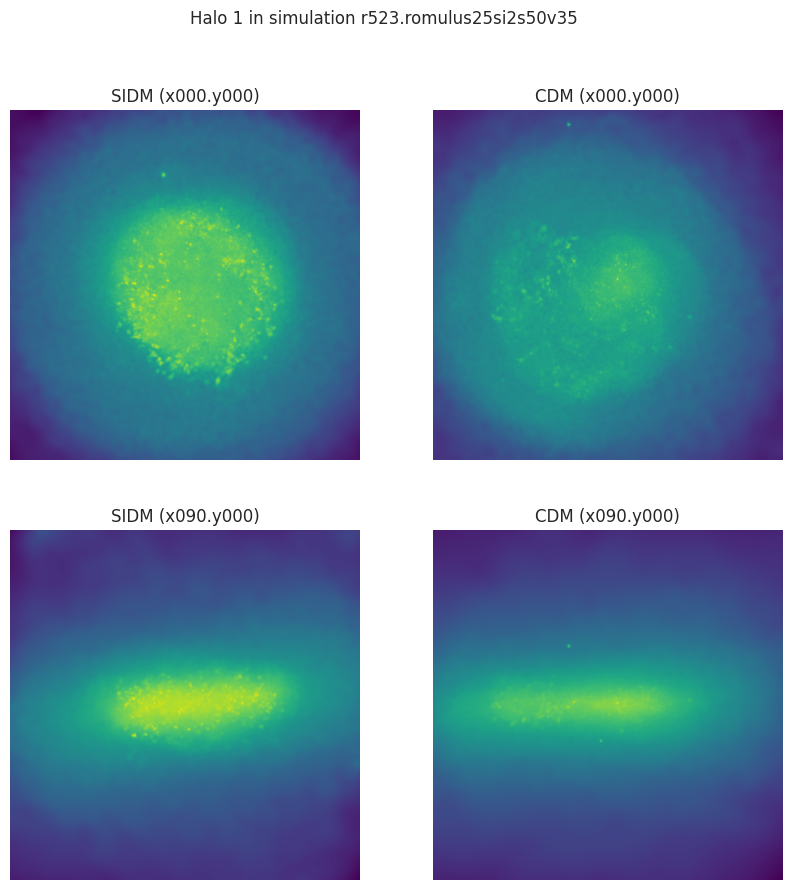

r618
Processing simulation: r618.romulus25si2s50v35
SIDM Stellar b/a: 0.56, c/a: 0.42
CDM Stellar b/a: 0.51, c/a: 0.44
Difference b/a: 0.06, c/a: -0.02
SIDM jz/jcirc: 0.00, jcrit: 0.57, dt_star: 0.00, dt_gas: 0.10, dt_total: 0.09
CDM jz/jcirc: 0.01, jcrit: 0.28, dt_star: 0.00, dt_gas: 0.11, dt_total: 0.10
Difference jz/jcirc: -0.01, jcrit: 0.29, dt_star: 0.00, dt_gas: -0.01, dt_total: -0.01


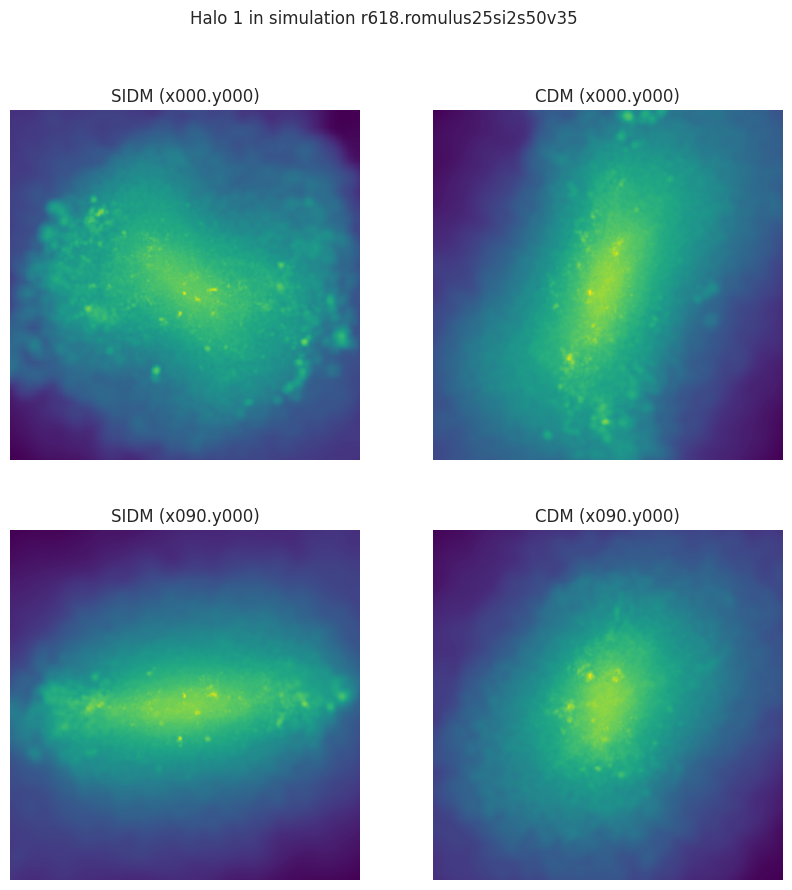

r431
Processing simulation: r431.romulus25cvdXsec
SIDM Stellar b/a: 0.86, c/a: 0.23
CDM Stellar b/a: 0.94, c/a: 0.20
Difference b/a: -0.08, c/a: 0.03
SIDM jz/jcirc: 246.39, jcrit: 0.32, dt_star: 0.54, dt_gas: 0.67, dt_total: 0.69
CDM jz/jcirc: 0.52, jcrit: 0.34, dt_star: 0.46, dt_gas: 0.80, dt_total: 0.79
Difference jz/jcirc: 245.87, jcrit: -0.02, dt_star: 0.08, dt_gas: -0.13, dt_total: -0.10


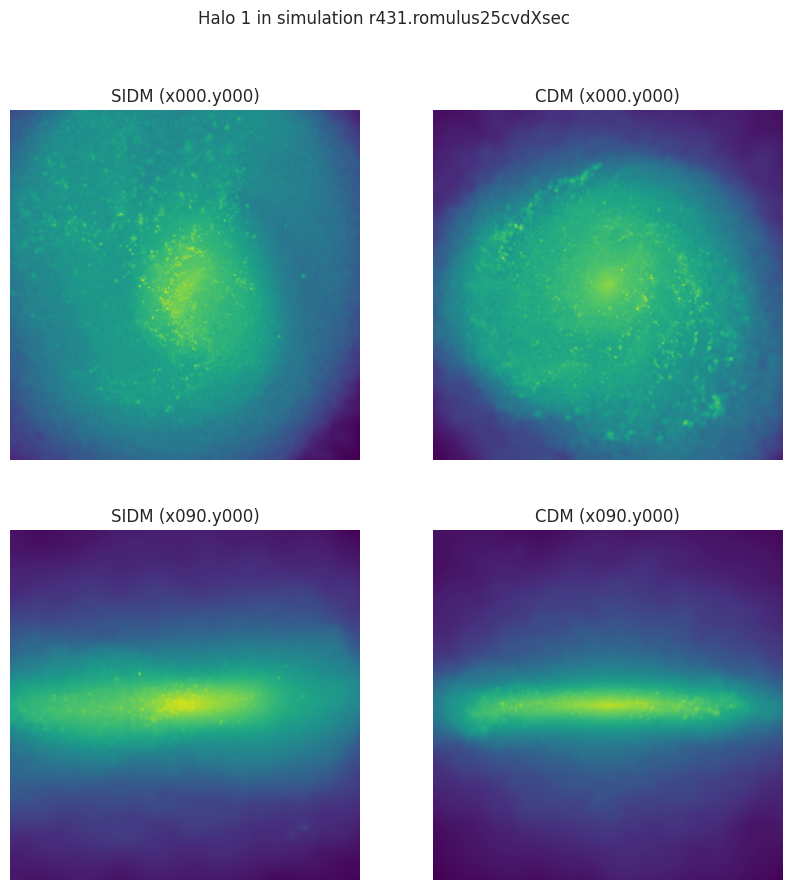

r492
Processing simulation: r492.romulus25cvdXsec
SIDM Stellar b/a: 0.65, c/a: 0.21
CDM Stellar b/a: 0.70, c/a: 0.21
Difference b/a: -0.05, c/a: -0.01
SIDM jz/jcirc: 0.34, jcrit: 0.19, dt_star: 0.09, dt_gas: 0.63, dt_total: 0.63
CDM jz/jcirc: 0.30, jcrit: 0.21, dt_star: 0.06, dt_gas: 0.62, dt_total: 0.61
Difference jz/jcirc: 0.04, jcrit: -0.02, dt_star: 0.03, dt_gas: 0.01, dt_total: 0.02


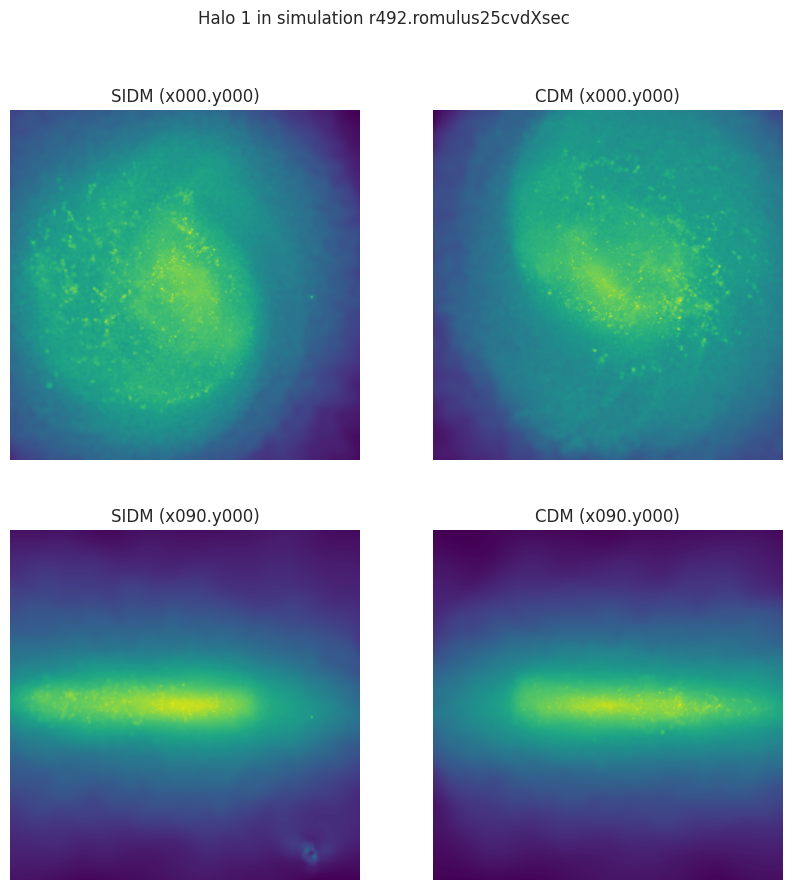

Classification complete. Results saved.


In [19]:
import os
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import traceback
import numpy as np

def extract_number(sim_name):
    return sim_name.split('.')[0][1:]

feedbacks = ['MerianSIDM', 'MerianCDM']
classifications = ['d', 'e', 'i']
output_folder = '../../Figures/Images/Classified'

# Load SIDM simulations
sidm_pickle_path = f'../PickleFiles/SimulationInfo.MerianSIDM.pickle'
cdm_pickle_path = f'../PickleFiles/SimulationInfo.MerianCDM.pickle'

classified_galaxies = {}

if os.path.exists(sidm_pickle_path) and os.path.exists(cdm_pickle_path):
    sidm_sims = pickle.load(open(sidm_pickle_path, 'rb'))
    cdm_sims = pickle.load(open(cdm_pickle_path, 'rb'))
    for sim in sidm_sims:
        try:
            sidm_dmshapes = pickle.load(open(f'../../Data/{sim}.MerianSIDM.DMShapes.pickle', 'rb'))
            sidm_stshapes = pickle.load(open(f'../../Data/{sim}.MerianSIDM.3DShapes.pickle', 'rb'))
            sidm_profiles = pickle.load(open(f'../../Data/{sim}.MerianSIDM.Profiles.pickle', 'rb'))
            sidm_masses = pickle.load(open(f'../../Data/BasicData/MerianSIDM.Masses.pickle', 'rb'))
            #extract number from sim name
            sim_number = extract_number(sim)
            CDM = f'r{sim_number}'
            print(CDM)

            cdm_dmshapes = pickle.load(open(f'../../Data/{CDM}.MerianCDM.DMShapes.pickle', 'rb'))
            cdm_stshapes = pickle.load(open(f'../../Data/{CDM}.MerianCDM.3DShapes.pickle', 'rb'))
            cdm_profiles = pickle.load(open(f'../../Data/{CDM}.MerianCDM.Profiles.pickle', 'rb'))
            cdm_masses = pickle.load(open(f'../../Data/BasicData/MerianCDM.Masses.pickle', 'rb'))
        except:
            print(f"Error loading shapes for simulation {sim}")
            print(traceback.format_exc())
            continue

        print(f"Processing simulation: {sim}")

        for hid in sidm_sims[sim]['goodhalos']:
            if hid not in cdm_sims[CDM]['goodhalos']:
                print(f"Halo {hid} not found in CDM simulation, skipping.")
                continue

            fig, axs = plt.subplots(2, 2, figsize=(10, 10))
            rotations = ['x000.y000', 'x090.y000']

            try:
                for i, rot in enumerate(rotations):
                    sidm_img = Image.open(f'../../Figures/Images/{sim}.MerianSIDM/{hid}/{hid}.{rot}.png')
                    cdm_img = Image.open(f'../../Figures/Images/{CDM}.MerianCDM/{hid}/{hid}.{rot}.png')
                    axs[i, 0].imshow(sidm_img)
                    axs[i, 0].set_title(f'SIDM ({rot})')
                    axs[i, 0].axis('off')
                    axs[i, 1].imshow(cdm_img)
                    axs[i, 1].set_title(f'CDM ({rot})')
                    axs[i, 1].axis('off')

                fig.suptitle(f'Halo {hid} in simulation {sim}')
            except:
                print(f"Error loading image for halo {hid}")
                print(traceback.format_exc())
                continue

            try:
                sidm_reff = sidm_profiles[str(hid)]['x000y000']['Reff']
                sidm_ba = sidm_stshapes[(hid)]["ba_smooth"](sidm_reff)
                sidm_ca = sidm_stshapes[(hid)]["ca_smooth"](sidm_reff)

                cdm_reff = cdm_profiles[str(hid)]['x000y000']['Reff']
                cdm_ba = cdm_stshapes[(hid)]["ba_smooth"](cdm_reff)
                cdm_ca = cdm_stshapes[(hid)]["ca_smooth"](cdm_reff)

                print(f'SIDM Stellar b/a: {sidm_ba:.2f}, c/a: {sidm_ca:.2f}')
                print(f'CDM Stellar b/a: {cdm_ba:.2f}, c/a: {cdm_ca:.2f}')
                print(f'Difference b/a: {sidm_ba - cdm_ba:.2f}, c/a: {sidm_ca - cdm_ca:.2f}')
            except:
                print(f"Error getting b/a, c/a for halo {hid}")
                print(traceback.format_exc())
            #print('Masses')
            #print(sidm_masses)
            try:
                sidm_jz_jcirc_avg = sidm_masses[sim][str(hid)]['jz_jcirc_avg']
                sidm_j_crit = sidm_masses[sim][str(hid)]['j_crit']
                sidm_dt_star = sidm_masses[sim][str(hid)]['dt_star']
                sidm_dt_gas = sidm_masses[sim][str(hid)]['dt_gas']
                sidm_dt_total = sidm_masses[sim][str(hid)]['dt_total']

                cdm_jz_jcirc_avg = cdm_masses[CDM][str(hid)]['jz_jcirc_avg']
                cdm_j_crit = cdm_masses[CDM][str(hid)]['j_crit']
                cdm_dt_star = cdm_masses[CDM][str(hid)]['dt_star']
                cdm_dt_gas = cdm_masses[CDM][str(hid)]['dt_gas']
                cdm_dt_total = cdm_masses[CDM][str(hid)]['dt_total']

                print(f'SIDM jz/jcirc: {sidm_jz_jcirc_avg:.2f}, jcrit: {sidm_j_crit:.2f}, dt_star: {sidm_dt_star:.2f}, dt_gas: {sidm_dt_gas:.2f}, dt_total: {sidm_dt_total:.2f}')
                print(f'CDM jz/jcirc: {cdm_jz_jcirc_avg:.2f}, jcrit: {cdm_j_crit:.2f}, dt_star: {cdm_dt_star:.2f}, dt_gas: {cdm_dt_gas:.2f}, dt_total: {cdm_dt_total:.2f}')
                print(f'Difference jz/jcirc: {sidm_jz_jcirc_avg - cdm_jz_jcirc_avg:.2f}, jcrit: {sidm_j_crit - cdm_j_crit:.2f}, dt_star: {sidm_dt_star - cdm_dt_star:.2f}, dt_gas: {sidm_dt_gas - cdm_dt_gas:.2f}, dt_total: {sidm_dt_total - cdm_dt_total:.2f}')
            except:
                print(f"Error getting jz/jcirc for halo {hid}")
                print(traceback.format_exc())

            plt.show()
            plt.pause(0.2)

            #fig.suptitle(f'Halo {hid} in simulation {sim} is {user_input}')

            # Create the output folder if it doesn't exist
            os.makedirs(output_folder, exist_ok=True)

            # Save the image in the classified folder
            #output_file = f'{output_folder}/{sim}.SIDM_CDM_comparison.{hid}.{user_input}.png'
            #fig.savefig(output_file)


    print("Classification complete. Results saved.")
else:
    print("Error: One or both pickle files not found.")

In [12]:
#does file ../../Data/r492.romulus25cvdXsec.MerianCDM.DMShapes.pickle exist
import os
import pickle
import traceback

try:
    DMShapes = pickle.load(open(f'../../Data/r492.romulus25cvdXsec.MerianCDM.DMShapes.pickle', 'rb'))
    print(DMShapes)
except:
    print(f"Error loading shapes for simulation {sim}")
    print(traceback.format_exc())

Error loading shapes for simulation r492.romulus25cvdXsec
Traceback (most recent call last):
  File "/tmp/ipykernel_1518703/1123723498.py", line 7, in <module>
    DMShapes = pickle.load(open(f'../../Data/r492.romulus25cvdXsec.MerianCDM.DMShapes.pickle', 'rb'))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 324, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '../../Data/r492.romulus25cvdXsec.MerianCDM.DMShapes.pickle'

